### import library

In [131]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, f1_score, recall_score, roc_auc_score, precision_score,
                                average_precision_score, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.inspection import DecisionBoundaryDisplay
import os
import warnings
warnings.filterwarnings('ignore')

### audio signal processing

In [ ]:
def sort_audio_path(addr_list: list, key: str):
    df = pd.DataFrame(addr_list)
    df["id"] = df[0].apply(lambda x : int(x.split("_")[0].split(key)[1]))
    df.sort_values(by="id", inplace=True)
    return df[0].to_list()

sound_path = os.listdir("../dataset/Audio Files")
BP_addr = "../dataset/Audio Files/" + sound_path[0] + "/"
DP_addr = "../dataset/Audio Files/" + sound_path[1] + "/"
EP_addr = "../dataset/Audio Files/" + sound_path[2] + "/"
BP_ls = os.listdir("../dataset/Audio Files/" + sound_path[0])
DP_ls = os.listdir("../dataset/Audio Files/" + sound_path[1])
EP_ls = os.listdir("../dataset/Audio Files/" + sound_path[2])

BP_ls = sort_audio_path(BP_ls, "BP")
DP_ls = sort_audio_path(DP_ls, "DP")
EP_ls = sort_audio_path(EP_ls, "EP")

### extract audio features

In [3]:
def extract_audio_features(audio_file_address, key, sr=22050, n_mfcc=40):
    y, sr = librosa.load(audio_file_address, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    zcr = librosa.feature.zero_crossing_rate(y)

    features = {}
    for i in range(n_mfcc):
        features[f'{key}_mfcc_{i+1}_mean'] = np.mean(mfcc[i])
        features[f'{key}_mfcc_{i+1}_std']  = np.std(mfcc[i])
        features[f'{key}_delta_mfcc_{i+1}_mean'] = np.mean(delta_mfcc[i])
        features[f'{key}_delta_mfcc_{i+1}_std']  = np.std(delta_mfcc[i])
        features[f'{key}_delta2_mfcc_{i+1}_mean'] = np.mean(delta2_mfcc[i])
        features[f'{key}_delta2_mfcc_{i+1}_std']  = np.std(delta2_mfcc[i])

    features[f'{key}_zcr_mean'] = np.mean(zcr)
    features[f'{key}_zcr_std']  = np.std(zcr)

    return pd.DataFrame([features])


In [ ]:
BP_df = pd.DataFrame()
DP_df = pd.DataFrame()
EP_df = pd.DataFrame()

for audio in BP_ls: BP_df = pd.concat([BP_df, extract_audio_features(BP_addr + audio, "BP")], ignore_index=True)
for audio in DP_ls: DP_df = pd.concat([DP_df, extract_audio_features(DP_addr + audio, "DP")], ignore_index=True)
for audio in EP_ls: EP_df = pd.concat([EP_df, extract_audio_features(EP_addr + audio, "EP")], ignore_index=True)

audio_features = pd.concat([BP_df, DP_df, EP_df], axis=1)
audio_features.to_csv("../dataset/audio_features.csv", index= False)

### preprocessing

In [ ]:
audio_features = pd.read_csv("../dataset/audio_features.csv")
labels = pd.read_csv("../dataset/label.csv")

corr_matrix = audio_features.corr(method='spearman')

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.9)]

audio_features_reduced = audio_features.drop(columns=to_drop)

ss = StandardScaler()
for col in audio_features_reduced.columns:
    audio_features_reduced[col] = ss.fit_transform(audio_features_reduced[[col]])

pca = PCA(n_components=0.95)
audio_features_reduced_pca = pca.fit_transform(audio_features_reduced)
audio_features_reduced_pca_df = pd.DataFrame(
    audio_features_reduced_pca,
    columns=[f"features_{i+1}" for i in range(audio_features_reduced_pca.shape[1])]
)


In [140]:
X = audio_features_reduced_pca_df.copy()
y = labels["Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 12, random_state=42)

### model design and training

In [141]:
svm_model = SVC(
        kernel="rbf",
        C=10,
        gamma="scale",
        class_weight="balanced",
        probability=True,
        random_state=42
    )

svm_model.fit(X_train, y_train)

,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


### model evalution

In [155]:
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)[:, 1]


print(f"Model: SVM")
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred, pos_label="ABNORMAL")*100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred, pos_label="ABNORMAL")*100:.2f}%")
print(f"F1: {f1_score(y_test, y_pred, pos_label="ABNORMAL")*100:.2f}%")

Model: SVM
Accuracy: 91.67%
Recall: 88.89%
Precision: 100.00%
F1: 94.12%


### performance plot

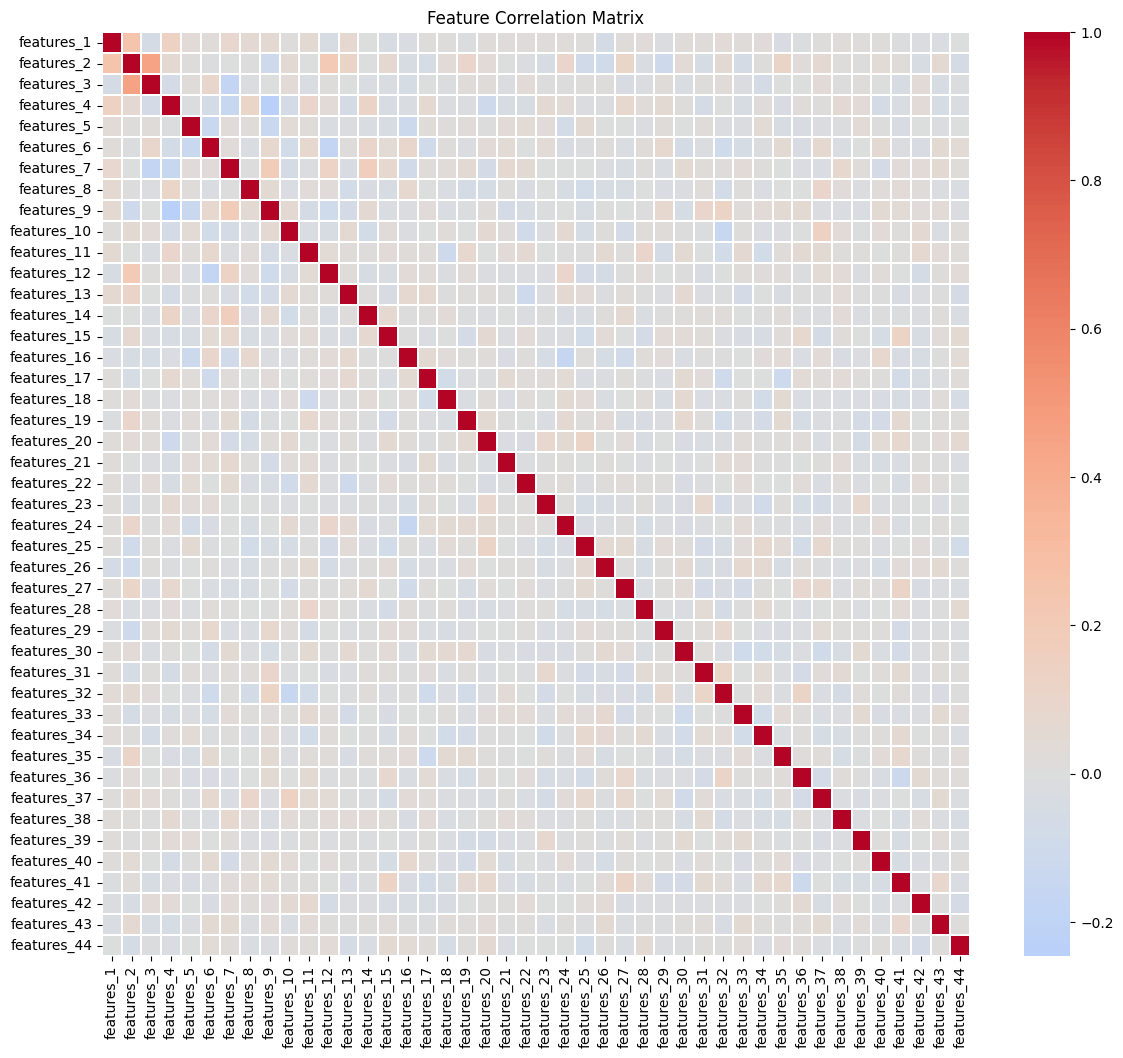

In [143]:
corr_matrix = audio_features_reduced_pca_df.corr(method='spearman')

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    linewidths=0.3
)

plt.title("Feature Correlation Matrix")
plt.show()

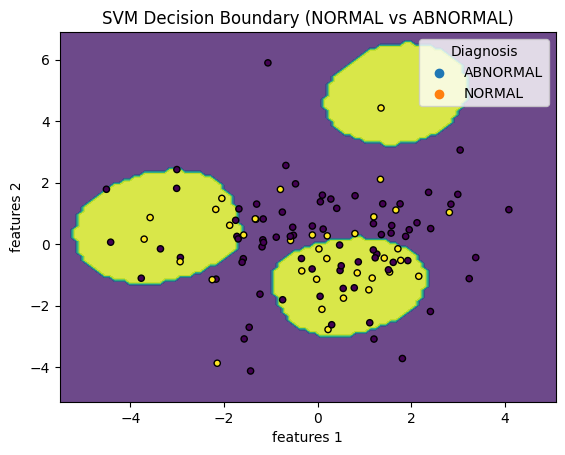

In [154]:
X_2d = audio_features_reduced_pca_df[['features_21', 'features_25']].values
y_label = labels.values

le = LabelEncoder()
y_enc = le.fit_transform(y_label.ravel())

svm_model_per = SVC(
        kernel="rbf",
        C=1,
        gamma="scale",
        class_weight="balanced",
        probability=True,
        random_state=42
    )

svm_model_per.fit(X_2d, y_enc)

DecisionBoundaryDisplay.from_estimator(
    svm_model_per,
    X_2d,
    response_method="predict",
    alpha=0.8
)

# Scatter plot
plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=y_enc,
    s=20,
    edgecolors="k"
)

plt.xlabel("features 1")
plt.ylabel("features 2")
plt.title("SVM Decision Boundary (NORMAL vs ABNORMAL)")
for label, name in zip([0, 1], le.classes_): plt.scatter([], [], label=name)
plt.legend(title="Diagnosis")

plt.show()

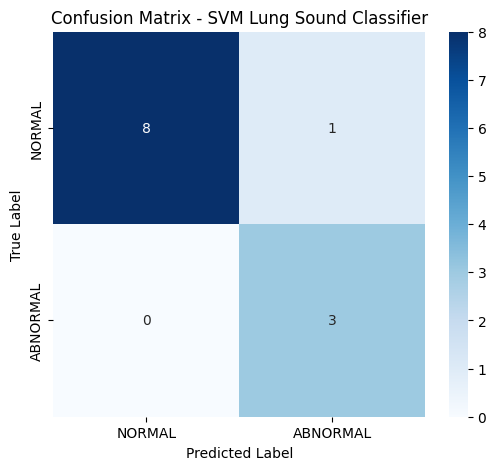

In [149]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["NORMAL", "ABNORMAL"],
    yticklabels=["NORMAL", "ABNORMAL"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM Lung Sound Classifier")
plt.show()